
# Final model Capstone Project ( May, 2020)
### Development and Application of an Immunization Network Design Optimization Model 
#### Henrique Ribeiro Carretti https://www.linkedin.com/in/hrcarretti/
#### Yuto Hashimoto: https://www.linkedin.com/in/yuto-hashimoto-2b529917a/

### 1.Load Libraries

In [112]:
import sys
import numpy as np
import math
import random
import pandas as pd
from scipy.spatial import distance
from haversine import haversine
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import xlwt
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

### 2. Define Classes

In [2]:
class health_center:
    """
    A class used to represent the health facilities
    Parameters
    ----------
    x : float 
        the latitude location
    y : float
        the longitude of location
    ID : str 
        a (preferrably unique) identifier of the health facility  
    """
    def __init__(self, x, y, ID, name):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.ID = str(name)
        self.type = 'health_facility'
        self.closestNetworkNode = None

In [3]:
class outreach_center:
    """
    A class used to represent the outreach centers
    Parameters
    ----------
    lat : float
        the latitude location
    lon : float
        the longitude of location
    ID : str
        a (preferrably unique) identifier of the health facility
    ----------

    """
    def __init__(self,x,y,name,ID):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.NAME = str(name)
        self.type = 'outreach_center'      
        self.closestNetworkNode = None

In [23]:
class population_center:
    """
    A class used to represent the outreach centers
    Parameters
    ----------
    lat : float
        the latitude location
    lon : float
        the longitude of location
    ID : str
        a  unique  identifier of the population set
    D : float
        Monthly vaccine doses demand of population region
    Other Attributes
    ----------
    """
    
    def __init__(self,x, y,ID,name,D):

        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        self.ID = str(ID)
        self.name = str(name)
        self.type = 'Population sets'
        self.D = float (D)
        
        self.closestNetworkNode = None

### 3.  Retrieves the gambia Open street maps road network and store in a variable called G

In [5]:
buffer_m = 500 # Retrieve the entire gambia network + a border of 500 meter
from_place = 'gambia' 
if from_place == None:
    
        g = ox.graph_from_bbox(
            ymax, ymin, xmax, xmin,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True
        )
        
else:
        
        g = ox.graph_from_place(
            from_place,
            network_type = 'drive',
            truncate_by_edge = True,
            clean_periphery = True,
            buffer_dist = buffer_m # meters
        )   


### 5.Demand coverage function

In [9]:
def calc_demand_factor ( origin, dest, distances, minimum=1, maximum=5, shape = 'linear',k=1.6 ):

    """
    Calculates a Euclidian distance

    Parameters
    ----------
    origin: float
        outreach site or fixed health center
    dest:float
        population region centroid
    min : float
        the maximum distance, in km, where coverage is 100 %
    shape: str
        Determines the shape of the function, either linear or exponential decay
    max: float
        the  distance, in km, from which  coverage is 100 %t 
    -------
    alfa : float
        Demand coverage factor, range between 0 and 1
    """

    if shape == 'linear':
        alfa=0
        if distances[(origin,dest)] < minimum:
            alfa = 1
        elif distances[(origin,dest)] < maximum:
            alfa = maximum/(maximum-minimum) - (1/(maximum-minimum))*distances[(origin,dest)]
        else:
            alfa =0
    elif shape == 'exp_decay_lower':
        alfa=0
        if distances[(origin,dest)] < minimum:
            alfa = 1
        elif distances[(origin,dest)] < maximum:
            alfa = 1/k ** (distances[(origin,dest)]-2) 
      
    elif shape == 'exp_decay_higher':
        alfa=0
        if distances[(origin,dest)] < minimum:
            alfa = 1
        elif distances[(origin,dest)] < maximum:
            alfa = ( maximum/(maximum-minimum) - (1/(maximum-minimum))*distances[(origin,dest)]  -
                    1/k ** (distances[(origin,dest)]-2)) +maximum/(maximum-minimum) - (1/(maximum-minimum))*distances[(origin,dest)]
            
            if alfa >1:
                alfa =1
            
    return alfa


### 6.Distance and mapping functions

#### The functions from  section 6 are adapted from class material of class SCM293, Urban Last MIle logistics. 
#### Author: Matthias Winkenbach, PhD - mwinkenb@mit.edu - https://megacitylab.mit.edu/

In [11]:
def calc_dist(orig,dest,mode='Euclidian'):
    """
    Calculates a Euclidian distance

    Parameters
    ----------
    orig : customer or depot object
        origin node
    dest : customer or depot object
        destination node
    mode : string
        type of distance metric to use (Euclidian or Haversine)

    Returns
    -------
    dist : float
        Distance between origin and destination node
    """
    if mode == 'Euclidian':
            dist =  math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2) 
    elif mode == 'Haversine':
        dist = haversine([orig[0],orig[1]],[dest[0],dest[1]])
    else:
        dist = None
        print("Undefined distance metric.")
    
    return dist

In [12]:
def closestNode(nodes, v, invDict):
    """
    Returns the closest node (i.e., intersection) on an OSM road network graph to an arbitrary point in space.
    Parameters
    ----------
    nodes: array-like of node locations (tuples)
    v: point to test
    invDict: dictionary of node location to node ID
    """
    
    # Function that returns the location of the node that is closest to the point tested
    closest = min(nodes, key=lambda p: haversine([v[0],v[1]],[p[0],p[1]]))
    # based on that location, return the ID of the closest node
    return invDict[closest]

In [13]:
def projectDataOSM(point_data, graph, Save=False, filename=None):
    """
    Snaps point data (e.g., customers and their demand information) to an underlying road network represented by a graph.

    Parameters
    ----------
    point_data : pandas dataframe 
        data frame containing data that can be tied to geographical locations (e.g., customer demand)
    graph : graph object
        graph representation of the underlying road network (from Networkx or OSMnx)
    Save : boolean
        whether or not the point data and the corresponding closest road network nodes should be saved to a CSV file
        default: False
    filename : string
        filename to use in case Save is set to True
        default: None

    Returns
    -------
    Nothing
    """
    
    # Create dictionary that maps the (x,y) locations of nodes (keys) to the respective node IDs (values)
    network_nodes = {}
    for n in graph.nodes.keys():
        network_nodes[(graph.nodes[n]['y'],graph.nodes[n]['x'])] = n
        
    # Snap each point in the point data to its nearest road network node (intersection)
    # - Initialize an empty list that will have the closest network node
    nodes = []
    # - Initialize an empty list that will have the closest network Latitude
    y = []
    # - Initialize an empty list that will have the closest network Longitude
    x=[]
    # - Initialize an empty list that will have the distance betweeen road node and original node
    dist=[]
    # - Iterate through every row of the point data (i.e., every point)
    for index,row in tqdm(point_data.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        close_node_key = closestNode(network_nodes.keys(), (row.lat,row.lng), network_nodes)
        nodes.append(close_node_key)
        y.append(graph.nodes[close_node_key]['y'])
        x.append(graph.nodes[close_node_key]['x'])
        dist.append ( haversine([row.lat,row.lng],[graph.nodes[close_node_key]['y'],graph.nodes[close_node_key]['x']])         )
                       
    # - Add the list of closest road network nodes to the data frame containing the point data
    point_data['closest_nw_node'] = nodes
    point_data['y'] = y
    point_data['x'] = x
    point_data['dist'] = dist
    
    # Save point data including the nearest node information to a CSV file (optional)
    if Save==True:
        if filename == None:
            print('File name not specified.')
        else:
            point_data.to_csv(filename)

In [14]:
def mapDataOSM(demand_data, depot_data,g, snap_to_grid=True, route_data=None, route_colors='green', Plot=True, from_place=None, buffer_m=1500,):
    """
    Takes customer demand data and depot information (i.e., point data), snaps it to the underlying road network 
    and plots it on a map.
    Optionally also displays routes (i.e., sequences of road network arcs travelled on) on that same map.
    
    Parameters
    ----------
    demand_data : pandas data frame 
        Data frame containing all customer location specific demand data
    depot_data : pandas data frame
        Data frame containing all available depot locations
    g : networkx graph object        
    snap_to_grid : boolean
        Whether or not the point data (demand_data and depot_data) still needs to be matched up with the closest
        nodes of the underlying road network.
        default: True
    
    route_data : list of lists of road network node IDs
        Route information to be plotted (if any)
        default: None
    route_colors : string
        TBD
        default: 'green'
    Plot : boolean
        Whether or not to plot the data on a map
        default: True

    Returns
    -------
    fig, ax : figure and axis objects
        required for plotting
    """  
        # Get bounding box of customer locations and print its coordinates
    
    print('Bounding box of point data:')
    ymax = max(demand_data.lat.append(demand_data.lat))
    print(ymax,'y max')
    ymin = min(demand_data.lat.append(demand_data.lat))
    print(ymin,'y min')
    xmax = max(demand_data.lng.append(demand_data.lng))
    print(xmax,'x max')
    xmin = min(demand_data.lng.append(demand_data.lng))
    print(xmin,'x min')
    
    if from_place != None:
        print('Place name used instead to retrieve road network:')
        print(from_place)
        
    # Snap each point to nearest node (intersection) on road network graph
###------ To reduce run time, snap the data points outside the function ### -------------   
    if snap_to_grid==True:
        print('Snapping point data to road network...')
        projectDataOSM(demand_data, g)
        projectDataOSM(depot_data, g)
    else:
        print('Assuming nodes already projected on OSM graph.')

#### --------------------------------------------------------------------------------------    
    # Plot on network   
    
    if Plot==True:
        print('Plotting data on map...')
        if route_data != None:
            
            fig, ax = ox.plot_graph_routes(g, 
                                           route_data, 
                                           fig_height=25, 
                                           node_size=2, 
                                           node_alpha=0.5,
                                           edge_linewidth=0.3, 
                                           route_alpha=0.3,
                                           route_color = route_colors,
                                           orig_dest_node_color = 'green',
                                           orig_dest_node_size = 4.0,
                                           route_linewidth = 2.5,
                                           dpi=300, 
                                           show=False, close=False)
            
        else:

            fig, ax = ox.plot_graph(g, fig_height=20, show=False, close=False, edge_alpha = 0.25, node_alpha = 0)
                   
        ax.scatter(demand_data.lng,
           demand_data.lat,
           alpha=1.0,
           color='red',
           marker='s',
           s=1)
        
        ax.scatter(depot_data.lng,
           depot_data.lat,
           alpha=1.0,
           color='blue',
           marker='s',
           s=10)

        plt.show()
    
    return g, fig, ax

In [16]:
###Compute a pairwise distance matrix for a list of nodes..

def d_matrix(origins, destinations,g=None,max_dist = 100, mode='Euclidian',returnPaths=False):
    """
    Calculates a distance matrix

    Parameters
    ----------
    origins : dict of  depot object
    destinations : dict of  destination object
       
    mode : str
        type of distance to use (Euclidian, Haversine, or OSM)
        default value: Euclidian

    Returns
    -------
    dist_mat : dict 
        origin-destination matrix of distances
    """
    path_mat = None
    if mode == 'Euclidian' or mode == 'Haversine':
        
        dist_mat = dict(
            [((i,j),calc_dist(origins[i].loc,destinations[j].loc,mode)) 
             for i in tqdm(origins) for j in destinations if calc_dist(origins[i].loc,destinations[j].loc,mode) <max_dist]
            )
        path_mat = None
        
        return dist_mat
        
    elif mode == 'OSM':
        if g == None:
            dist_mat = {}
            print("Network information missing.")
        else:
            dist_mat = dict(
                [((i,j),nx.shortest_path_length(g, origins[i].closestNetworkNode, destinations[j].closestNetworkNode, weight='length')) 
                 for i in tqdm(origins) for j in destinations]
            )
            if returnPaths == True:
                path_mat = dict(
                    [((i,j),nx.shortest_path(g, nodes[i].closestNetworkNode, nodes[j].closestNetworkNode)) 
                     for i in tqdm(origins) for j in destinations]
                )
            else:
                path_mat = None
            
            return dist_mat, path_mat  
    else: 
        dist_mat = {}
        path_mat = None
        print("Undefined distance metric.")
        
    return dist_mat, path_mat

### 7. Load the data

In [18]:
# load Population data 
# data input must have the following columns:  ID, Type, Name, lat, long
pop = pd.read_csv('population_2x2.csv')

In [19]:
# load health_facilities data 
# data input must have the following Columns: ID, Type, Name, lat, long
hc = pd.read_csv('Health facilities.csv')

In [20]:
# load outreach candidates data ( before snaping to road network)
# data input must have the following Columns: ID, Type, Name, lat, long
oc = pd.read_csv('Outreach center 2x2.csv')

### 8. Create the dictionaries of classes

In [22]:
# Population dictionary
population= dict([
     (pop.ID.iloc[i],
     population_center(
              pop.lat.iloc[i],
              pop.lng.iloc[i],
              pop.ID.iloc[i],
              pop.Name.iloc[i],
              pop.Population.iloc[i]*1.002/12 )) for i in range(len(pop)) ### THIS OPERATION CONVERTS THE TOTAL population of the region into vaccination doses requirement ( see section 4.2.3, Vaccination doses demand, of thesis)
])

In [26]:
# Outreach center dictionary
outreach_centers = dict([
    (oc.ID.iloc[i],
     outreach_center (
              oc.lat.iloc[i],
              oc.lng.iloc[i],
              oc.Name.iloc[i],
              oc.ID.iloc[i])) for i in range(len(oc))
])

In [27]:
# Health center dictionary
health_centers = dict([
    (hc.ID.iloc[i],
     health_center (
              hc.lat.iloc[i],
              hc.lng.iloc[i],
              hc.ID.iloc[i],             
              hc.Name.iloc[i])) for i in range(len(hc))
])

In [68]:
origins ={}
destination={}
nodes = {}
origins = {**outreach_centers,**health_centers}
destination = {**outreach_centers,**population}
nodes = {**population,**outreach_centers,**health_centers}

### 9. Node projection in road network

In [22]:
###--- Proeject the read outreach centers  in the road network, fiding the closest node of the network, be carefull takes 40 min to run-
##- Receives a data frame OC and the OSM graph and returns the data frame with closest network node latitude/longitude and its distance
projectDataOSM(oc, g, Save=False, filename=None)

3952it [10:25,  6.32it/s]


In [23]:
### Export the projected outreach centers to A CSV file
oc.to_csv('Outreach Centers with Road network point 2x2.csv')

In [25]:
### Add to the outreach object the closest network node 
for index,row in (oc.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        outreach_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

In [26]:
###--- Proeject the read HC in the OSM network, fiding the closest network, be carefull takes 40 min to run--- 
projectDataOSM(hc, g, Save=False, filename=None)

80it [00:18,  4.43it/s]


In [27]:
### Export the projected outreach centers to A CSV file
hc.to_csv('Health Centers with Road network point.csv')

In [29]:
### Add to the health_center object the closest network node 
for index,row in (hc.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        health_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

### 10. Filtering of duplicate outreach candidate  sites 

In [113]:
oc=pd.read_csv('Outreach Centers with Road network point 2x2.csv')

In [50]:
# the candidate site for outreacg will be a network node. If more than one point of the grid have as closest network node the same point
# only one point node shall be considered ( see section 4.2.7 of the capstone)
oc_filtered = pd.pivot_table(oc, values=['y','x'], index = 'closest_nw_node', aggfunc=[np.mean])
oc_filtered.columns = ['lng','lat', ]
oc_filtered = oc_filtered.reset_index()
oc_filtered['ID']= oc_filtered['closest_nw_node']
oc_filtered['Name']= oc_filtered['closest_nw_node']

In [51]:
##Updates the outreach centers candidates
outreach_centers={}
outreach_centers = dict([
    (oc_filtered.ID.iloc[i],
     outreach_center (
              oc_filtered.lat.iloc[i],
              oc_filtered.lng.iloc[i],
              oc_filtered.Name.iloc[i],
              oc_filtered.ID.iloc[i])) for i in range(len(oc_filtered))
])

In [52]:
### Add to the outreach object the closest network node 
for index,row in (oc_filtered.iterrows()):
        # - Find the closes road network node to that point and add it to the list
        outreach_centers[row.ID].closestNetworkNode =  (row.closest_nw_node)

### 11. Creates consolidated dictionary with all nodes

In [35]:
origins ={}
destination={}
nodes = {}
origins = {**outreach_centers,**health_centers}
destination = {**outreach_centers,**population}
nodes = {**population,**outreach_centers,**health_centers}
print ("origins, destination, total",len ( origins),len(destination),  len ( nodes))

origins, destination, total 2438 6310 6390


### 12  Road  Distance - calculationOSM ( takes 16 hours to run) - 
#### 12.1 USE THIS CODE BLOCK IF YOU DON'T HAVE THE DISTANCES CALCULATED IN A CSV

In [38]:
#pre - process in super computer and read the matrix through a csv file ( takes so much because it solves the shortest path problem for each OD )
dist_f_o_OSM=  d_matrix(health_centers, outreach_centers,g,max_dist = 100, mode='OSM',returnPaths=False)


100%|██████████| 80/80 [00:01<00:00, 57.27it/s]


In [ ]:
dist_f_o_OSM  = dist_f_o_OSM[0]

In [76]:
### This code block creates a data frame and exports the road distances, this avoids that the road distance calculation need to be done every time
df_dist_f_o_OSM = pd.DataFrame(columns=['key', 'distance[Km]'])
for key in dist_f_o_OSM:
    df_dist_f_o_OSM = df_dist_f_o_OSM.append({'key':  key ,'distance[m]': dist_f_o_OSM[key]} ,ignore_index = True)       
df_dist_f_o_OSM.to_csv('OSM_road_network_distances.csv')


#### 12.2  USE THIS CODE BLOCK IF YOU  HAVE THE DISTANCES ALREADY CALCULATED IN A CSV

In [58]:
## we are only reading the OD pairs that have a distance lower than 35 km , can be customizable
df_dist_osm = pd.read_csv('OSM_road_network_distances_full_2x2_les35000.CSV') 
print(str(len(df_dist_osm))+' df_dist_osm')

169573 df_dist_osm


In [57]:
dist_f_o_OSM= dict([
    (eval(df_dist_osm.key.iloc[i]) ,df_dist_osm.distance.iloc[i]) for i in range(len(df_dist_osm)) ])

### Nodes visualitzation

In [ ]:
# Project the full gridt it
myg, fig, ax = mapDataOSM(oc,hc,g, snap_to_grid=False, from_place = 'Gambia', buffer_m=500)

### 13 Calculate other distances 

In [88]:
### Linear distance from outreach center to population regions centroids
dist_o_j = {}
dist_o_j= d_matrix(outreach_centers, population,max_dist = 10,returnPaths=True,mode='Haversine')

100%|██████████| 2358/2358 [00:55<00:00, 42.40it/s]


In [63]:
### Linear distance from fixed health center  center to population regions centroids
dist_f_j= d_matrix(health_centers, population,max_dist = 10,returnPaths=True,mode='Haversine')

100%|██████████| 80/80 [00:01<00:00, 45.09it/s]


In [70]:
distances = {**dist_o_j,**dist_f_j,**dist_f_o_OSM }

### 14 .Demand of archs

In [71]:
### calculates the demand matrix to all the customers assuming the decrease in coverage due to increase in distance given in function calc_demand_factor
demand_mat = dict(
    [((i,j), calc_demand_factor (i,j,distances,2,10) * population[j].D )
             for i in origins for j in population if (i,j) in distances ]) 

### 15 .Input variables

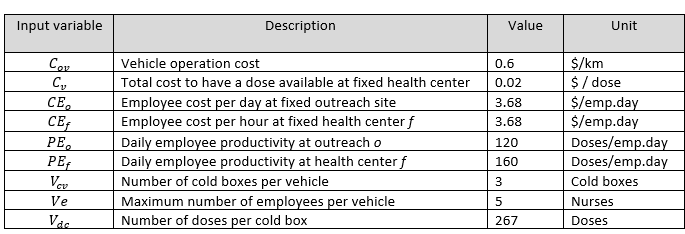

In [90]:
Budget = 12000
COv = 0.6  
CEo = 3.68
CEf = 3.68
PEo = 120 
PEf = 160  
Cfj = 0.02 + CEf/PEf
Coj = 0.02 + CEo/PEo 
Vcv = 3 
Vdc = 267 
Ve = 5 
PEo = 120 

### 16. Model initialization

In [73]:
m = gp.Model('Final model V1')
m.reset()
m.update()

Using license file C:\Users\carretti\gurobi.lic
Academic license - for non-commercial use only
Discarded solution information


### 17. Add Decision variables

In [75]:
#number of doses administrated to population in region j by outreach site o,
Xoj = dict(
    [((o,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Xoj_%s_%s" %(o,j))) 
     for o in outreach_centers 
     for j in population if (o,j)in dist_o_j ]
)

214684

In [77]:
# Total number of resource bundles sent from fixed health center f to outreach location o 
Xfo = dict(
    [((f,o), m.addVar(vtype=GRB.INTEGER, lb=0.0, name="Xfo_%s_%s" %(f,o))) 
     for f in health_centers 
     for o in outreach_centers if (f,o)in dist_f_o_OSM ]
)

In [78]:
Xfj = dict(
    [((f,j), m.addVar(vtype=GRB.CONTINUOUS, lb=0.0, name="Xfj_%s_%s" %(f,j))) 
     for f in health_centers
     for j in population if (f,j)in dist_f_j ]
)

In [79]:
Yfj = dict(
    [((f,j), m.addVar(vtype=GRB.BINARY, lb=0.0, name="Yfj_%s_%s" %(f,j))) 
     for f in health_centers 
     for j in population if (f,j)in dist_f_j  ]
)

In [80]:
Yoj = dict(
    [((o,j), m.addVar(vtype=GRB.BINARY, lb=0.0, name="Yoj_%s_%s" %(o,j))) 
     for o in outreach_centers 
     for j in population if (o,j)in dist_o_j  ]
)

### 18 Set Optimization Objective

In [82]:
m.setObjective(
    quicksum([Xoj[(o,j)] 
              for o in outreach_centers 
              for j in population if (o,j)in dist_o_j ])
     +quicksum([Xfj[(f,j)] 
              for f in health_centers 
              for j in population if (f,j)in dist_f_j ])
   ,
              GRB.MAXIMIZE)

### 19 Add Constraints

In [83]:
### (3) Demand constraint for health centers archs
C_1= dict(
    [((f,j),m.addConstr( Xfj[(f,j)]
                                <= 
                        demand_mat[(f,j)]*Yfj[(f,j)]
                     ,                "Health_facility_demand_arch_%s_%s"%(f,j)) )
     for f in health_centers 
     for j in population if (f,j)in dist_f_j]
)

In [84]:
### (4) Demand constraint for outreaches
C_2= dict(
    [((o,j),m.addConstr( Xoj[(o,j)]
                                <= 
                    demand_mat[(o,j)]*Yoj[(o,j)]
                     ,                "Outreach_demand_arch_%s_%s"%(o,j)) )
     for o in outreach_centers 
     for j in population if (o,j)in dist_o_j ]
)

In [85]:
### (6) Single source constraint 
C_7 = dict(
    [((j),m.addConstr( quicksum(Yfj[(f,j)]  for f in health_centers if (f,j)in dist_f_j)+
                       quicksum(Yoj[(o,j)]  for o in outreach_centers if (o,j)in dist_o_j) 
                       <=
                       1
                      ,
    "single_service%s" %(j)))
     for j in population]
)

In [91]:
### (5.2 ) Flow conservation - Guarantee that cold box avaialability is respected
C_13 = dict(
    [((o),m.addConstr( quicksum(Xfo[(f,o)]* Vcv * Vdc  for f in health_centers if (f,o)in dist_f_o_OSM ) 
                       >=
                       quicksum(Xoj[(o,j)]  for j in population if (o,j)in dist_o_j)
                      ,
    "flow_conservation%s" %(o)))
     for o in outreach_centers]
)

In [92]:
### (5.1) Flow conservation - Guarantee that human resource availability is respected
C_14 = dict(
    [((o),m.addConstr( quicksum(Xfo[(f,o)]* Ve * PEo  for f in health_centers if (f,o)in dist_f_o_OSM ) 
                       >=
                       quicksum(Xoj[(o,j)]  for j in population if (o,j)in dist_o_j)
                      ,
    "flow_conservation%s" %(o)))
     for o in outreach_centers]
)

In [94]:
### Budget 
C_15 = dict(
    [('budget',m.addConstr( 
                        quicksum (Xfo[(f,o)]* ( COv * dist_f_o_OSM[(f,o)]/1000 +CEo)
                        for f in health_centers
                        for o in outreach_centers
                        if (f,o)in dist_f_o_OSM)
        +
                        quicksum (Xfj[(f,j)]*Cfj   
                        for f in health_centers
                        for j in population
                        if (f,j)in dist_f_j)   
        +    
                        quicksum (Xoj[(o,j)]*Coj   
                        for o in outreach_centers
                        for j in population
                        if (o,j)in dist_o_j) 
        
                       <=
                       Budget                  ,
    "budget is respected") )
    ]
)

### 20 Optimize

In [95]:
# Set model parameters
m.Params.timelimit = 12000.0     # set maximum runtime in seconds
m.Params.MIPGap = 0.01         # set maximum allowable optimality gap (0.01 = 1%)

# Optimize model
m.optimize()

Changed value of parameter timelimit to 12000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.2
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 444766 rows, 823892 columns and 2243534 nonzeros
Model fingerprint: 0x54b189fd
Variable types: 436097 continuous, 387795 integer (221413 binary)
Coefficient statistics:
  Matrix range     [2e-05, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 228497 rows and 397853 columns (presolve time = 5s) ...
Presolve removed 228497 rows and 397853 columns
Presolve time: 8.88s
Presolved: 216269 rows, 426039 columns, 1071525 nonzeros
Variable types: 213850 continuous, 212189 integer (210144 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iter

### 21 Result analysis

In [97]:
## Calculates vehicle operation costs
cost_vehicle= 0
for f in health_centers:
        for o in outreach_centers:
            if (f,o)in dist_f_o_OSM:
                if (Xfo[(f,o)].X>0.1):
                    if ((f,o) != ('283_HC', 2562702299)): #erro na hora de importar a planilha, distancia ta zerada para essa od - nao muda o resultado pq didstnacia dela eh maior que 75 km
                    #cost_bundle =  Xfo[(f,o)].X *(distances[(f,o)]*CVfo + CFfo) + cost_bundle
                        cost_vehicle =  Xfo[(f,o)].X *(COv *dist_f_o_OSM[(f,o)]/1000 +CEo )+ cost_vehicle

In [98]:
## Outreach site cost ( vaccine + staff)
cost_outreach_emp_cold= 0
for o in outreach_centers:
        for j in population:
            if (o,j)in dist_o_j:
                if (Xoj[(o,j)].X>0.1):
                    #cost_bundle =  Xfo[(f,o)].X *(distances[(f,o)]*CVfo + CFfo) + cost_bundle
                    cost_outreach_emp_cold =  Xoj[(o,j)].X *Coj + cost_outreach_emp_cold


In [100]:
## Health center cost ( vaccine + staff)
cost_fixed_hc= 0
for f in health_centers:
        for j in population:
            if (f,j)in dist_f_j:
                if (Xfj[(f,j)].X>0.1):
                    cost_fixed_hc =  Xfj[(f,j)].X *Cfj + cost_fixed_hc

In [101]:
total_cost = cost_vehicle + cost_outreach_emp_cold + cost_fixed_hc

In [ ]:
print('total cost' , total_cost) 
print ('Fixed_hc_cost', cost_fixed_hc )
print ('Outreach_cost', cost_outreach_emp_cold +cost_vehicle  )

In [109]:
### Resource bundles flow Xfo Data frame
df_Xfo = pd.DataFrame(columns=['health_center_id', 'outreach_center_id', 'bundles','distance[Km]', ])
for f in health_centers:
        for o in  outreach_centers:
             if (f,o)in dist_f_o_OSM:
                if ( Xfo[(f,o)].X )>0.0001:
                    df_Xfo = df_Xfo.append({'health_center_id':  f ,'outreach_center_id':o,'bundles': round(Xfo[(f,o)].X,2), 'distance[Km]': distances[(f,o)]/1000 } ,ignore_index = True)           

In [110]:
### Fixed health center vaccine flow Xfj Data frame
df_Xfj = pd.DataFrame(columns=['health_center_id', 'population_ID', 'Distributed_Doses','distance[Km]',
                               'Total_Doses_Demand', 'Reachness factor(%)'])
for f in health_centers:
        for j in  population:
            if (f,j)in dist_f_j:
                if ( Xfj[(f,j)].X )>0.0001:
                    df_Xfj = df_Xfj.append({'health_center_id':  f ,'population_ID':j,'Distributed_Doses': round(Xfj[(f,j)].X,2), 'distance[Km]': distances[(f,j)], 
                                            'Total_Doses_Demand':population[j].D, 'Reachness factor(%)': round(calc_demand_factor (f,j,distances,2,10) *100,1),  } ,ignore_index = True)           


In [111]:
### Fixed health center vaccine flow Xfj Data frame
df_Xoj = pd.DataFrame(columns=['outreach_center_id', 'population_ID', 'Distributed_Doses','distance[Km]',
                               'Total_Doses_Demand', 'Reachness factor(%)'])
for o in outreach_centers:
        for j in  population:
            if (o,j)in dist_o_j: 
                if (Xoj[(o,j)].X )>0.0001:
                    df_Xoj = df_Xoj.append({'outreach_center_id':  o ,'population_ID':j,'Distributed_Doses': round(Xoj[(o,j)].X,2), 'distance[Km]': distances[(o,j)]  ,
                                            'Total_Doses_Demand':population[j].D, 'Reachness factor(%)': round(calc_demand_factor (o,j,distances)*100,1),  } ,ignore_index = True)           

### Immunization KPI's

In [80]:
target_population=0
for i in population:
    target_population = population [i].D + target_population

In [81]:
print('Total immunization: %g' % round(m.objVal,0))
print('Total population %g'%round(target_population,0) )
print('Coverage %g '% round((m.objVal/target_population *100),1),"%" )


Total immunization: 166749
Total population 171753
Coverage 97.1  %


In [82]:
print('population nodes serviced by outreach: ', df_Xoj['population'].count())
print('population nodes serviced by fixed HC: ', df_Xfj['population'].count())

population nodes serviced by outreach:  3551
population nodes serviced by fixed HC:  394


In [83]:
print('total population serviced by outreach: %g' %  round(df_Xoj['immunized_children'].sum()))
print('total population service by fixed HC: %g'% round(df_Xfj['immunized_children'].sum()))

total population serviced by outreach: 110291
total population service by fixed HC: 56458


In [84]:
print ( df_Xoj['distance[Km]'].mean(),df_Xfj['distance[Km]'].mean())


2.1919837648638083 1.858273503012196


### Outreach operation KPI's

In [85]:
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))

number outreach facilities open: 449


In [86]:
#### basic outreach statistics
avg = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().mean()
maxi = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().max()
mini = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',(maxi))
print ('min',round(mini))
print ('avg',round(avg))

Basic statisitics of immunized children per open outreach
max 3415.1800000000003
min 41.0
avg 246.0


In [87]:
### Number of distinct outreach centers serviced from each HC
df_Xfo['outreach_center_id'].groupby(df_Xfo['health_center_id']).nunique().sum()

449

In [88]:
##distance

print ( ' average distance or from fixed center' , df_Xfo['distance[Km]'].mean()) 
print ( ' maximum distance or from fixed center' , df_Xfo['distance[Km]'].max()) 
print ( ' minimum distance or from fixed center' , df_Xfo['distance[Km]'].min()) 

 average distance or from fixed center 8.149091097995546
 maximum distance or from fixed center 26.083616000000003
 minimum distance or from fixed center 0.51516


### Fixed HC operation kpi's

In [89]:
print('number of opened HC: %g'% round(df_Xfj['health_center_id'].nunique()))

number of opened HC: 73


In [90]:
print('Number of bundles: %g'% round(df_Xfo['bundles'].sum()))

Number of bundles: 474


In [91]:
#### basic fixed hc statistics
avg = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().mean()
maxi = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().max()
mini = df_Xfj['immunized_children'].groupby(df_Xfj['health_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',(maxi))
print ('min',(min))
print ('avg',(avg))

Basic statisitics of immunized children per open outreach
max 6536.259999999999
min <built-in function min>
avg 773.3976712328767


#### PRINT KPI's

In [93]:
print('-----Costs-------')
print('total cost: ' , round(total_cost) )
print ('Fixed_hc_cost: ', round(cost_fixed_hc) )
print ('Outreach_cost: ', round(cost_vehicle + cost_outreach_emp_cold))
print('-----general coverage-------')
print('Total immunization: %g' % round(m.objVal,0))
print('Total population %g'%round(target_population,0) )
print('Coverage %g '% round((m.objVal/target_population *100),1),"%" )
print('-----Service by location type-------')
print('total population serviced by outreach: %g' %  round(df_Xoj['immunized_children'].sum()))
print('total population service by fixed HC: %g'% round(df_Xfj['immunized_children'].sum()))

print('population nodes serviced by fixed HC: ', df_Xfj['population'].count())


print('population nodes serviced by outreach: ', df_Xoj['population'].count())
print('-----OR operation-------')
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))
avg = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().mean()
maxi = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().max()
mini = df_Xoj['immunized_children'].groupby(df_Xoj['outreach_center_id']).sum().min()
print ('Basic statisitics of immunized children per open outreach')
print ('max',round(maxi))
print ('min',round(mini))
print ('avg',round(avg))
 
print('-----HC operation-------')
print('number of opened HC: %g'% round(df_Xfj['health_center_id'].nunique()))
print('Number of bundles sent : %g'% round(df_Xfo['bundles'].sum()))
print('number outreach facilities open: %g' %  round(df_Xoj['outreach_center_id'].nunique()))

print('---Distance health center to outreaches---------')
print ( ' average distance or from fixed center' , round(df_Xfo['distance[Km]'].mean()))
print ( ' maximum distance or from fixed center' , round(df_Xfo['distance[Km]'].max()) )
print ( ' minimum distance or from fixed center' , round(df_Xfo['distance[Km]'].min()) )

-----Costs-------
total cost:  11997.0
Fixed_hc_cost:  2428
Outreach_cost:  9569.0
-----general coverage-------
Total immunization: 166749
Total population 171753
Coverage 97.1  %
-----Service by location type-------
total population serviced by outreach: 110291
total population service by fixed HC: 56458
population nodes serviced by fixed HC:  394
population nodes serviced by outreach:  3551
-----OR operation-------
number outreach facilities open: 449
Basic statisitics of immunized children per open outreach
max 3415.0
min 41.0
avg 246.0
-----HC operation-------
number of opened HC: 73
Number of bundles sent : 474
number outreach facilities open: 449
---Distance health center to outreaches---------
 average distance or from fixed center 8.0
 maximum distance or from fixed center 26.0
 minimum distance or from fixed center 1.0


In [94]:
### Export flows to CSV
df_Xfo.to_csv('df_Xfj.csv')
df_Xfj.to_csv('df_Xfj.csv')
df_Xoj.to_csv('df_Xoj.csv')